# pp

In [1]:
!pip install tensorflow
import tensorflow as tf # <--- Tambahkan baris ini!
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, classification_report
import seaborn as sns
import itertools
import os
import time
import pandas as pd
from datetime import datetime
import random
import cv2
from datetime import datetime # Pastikan datetime diimpor jika belum
import json # Pastikan json diimpor jika belum

# Set seed untuk reprodusibilitas
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Konstanta
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.001
FINE_TUNING_LEARNING_RATE = 0.0001

RUN_TRAINING = False          # <--- TAMBAHKAN BARIS INI
RUN_PREDICTION_ON_NEW_IMAGE = True # <--- TAMBAHKAN BARIS INI



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 2. Plotting and Visualization Functions

In [2]:
def plot_history(history, batch_size, learning_rate, save_path=None):
    """Plot akurasi dan loss dari training history"""
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy (BS={batch_size}, LR={learning_rate})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss (BS={batch_size}, LR={learning_rate})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues, save_path=None):
    """Plot confusion matrix dengan opsi normalisasi"""
    plt.figure(figsize=(10, 8))

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    # Gunakan seaborn untuk heatmap yang lebih bagus
    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap,
                xticklabels=classes, yticklabels=classes,
                square=True, cbar=True)

    plt.title(title, fontsize=14)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def visualize_predictions(model, dataset, class_names, num_images=12, save_path=None):
    """Visualisasikan beberapa prediksi model"""
    plt.figure(figsize=(15, 10))

    images_shown = 0
    for images, labels in dataset:
        predictions = model.predict(images)
        pred_classes = np.argmax(predictions, axis=1)

        for i in range(len(images)):
            if images_shown >= num_images:
                break

            plt.subplot(3, 4, images_shown + 1)
            img = images[i].numpy().astype("uint8")
            plt.imshow(img)

            true_class = class_names[labels[i]]
            pred_class = class_names[pred_classes[i]]

            color = "green" if true_class == pred_class else "red"
            title = f"True: {true_class}\nPred: {pred_class}"

            plt.title(title, color=color)
            plt.axis("off")

            images_shown += 1

        if images_shown >= num_images:
            break

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# 3. Dataset Loading and Preprocessing

In [3]:
def load_dataset(directory, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE):
    """Memuat dataset dari direktori dengan penanganan kesalahan yang lebih baik"""
    try:
        # Periksa apakah direktori ada
        if not os.path.exists(directory):
            print(f"Direktori tidak ada: {directory}")
            return None, None

        # Periksa apakah direktori berisi file
        has_files = False
        for root, _, files in os.walk(directory):
            if files:
                has_files = True
                break

        if not has_files:
            print(f"Direktori kosong: {directory}")
            return None, None

        # Muat dataset
        dataset = keras.preprocessing.image_dataset_from_directory(
            directory,
            image_size=image_size,
            batch_size=batch_size,
            shuffle=True,
            seed=SEED,
            interpolation='bilinear',
            color_mode='rgb',
            crop_to_aspect_ratio=False,
        )

        class_names = dataset.class_names

        # Mengoptimalkan dataset untuk performa
        AUTOTUNE = tf.data.AUTOTUNE
        dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

        return dataset, class_names
    except Exception as e:
        print(f"Error memuat dataset dari {directory}: {e}")
        return None, None

# 4. Pre-trained Model Loading and Custom Layer

In [4]:
def load_pretrained_mobilenetv3(model_path):
    """Memuat model pre-trained MobileNetV3 Small dari path yang diberikan"""
    print(f"Mencoba memuat model pre-trained MobileNetV3 dari {model_path}...")

    try:
        print("Memuat model menggunakan tf.saved_model.load...")
        # Coba dengan berbagai tags untuk kompatibilitas
        try:
            saved_model = tf.saved_model.load(model_path, tags=['serve'])
            print("Berhasil memuat model dengan tag 'serve'")
        except Exception as e1:
            print(f"Gagal memuat model dengan tag 'serve': {e1}")
            try:
                saved_model = tf.saved_model.load(model_path, tags=[])
                print("Berhasil memuat model dengan tag kosong")
            except Exception as e2:
                print(f"Gagal memuat model dengan tag kosong: {e2}")
                try:
                    saved_model = tf.saved_model.load(model_path)
                    print("Berhasil memuat model tanpa menentukan tag")
                except Exception as e3:
                    print(f"Semua upaya memuat model gagal: {e3}")
                    return None

        if hasattr(saved_model, 'signatures'):
            print("Signatures yang tersedia:")
            for sig_name in saved_model.signatures:
                print(f"- {sig_name}")

        return saved_model
    except Exception as e:
        print(f"Error memuat model pre-trained: {e}")
        return None

# ... kode sebelumnya (misalnya setelah load_pretrained_mobilenetv3) ...

class SavedModelLayer(tf.keras.layers.Layer):
    def __init__(self, saved_model, model_path=None, **kwargs):
        super(SavedModelLayer, self).__init__(**kwargs)
        self.saved_model = saved_model
        self.model_path = model_path # Simpan hanya path

        if hasattr(saved_model, 'signatures'):
            if 'serving_default' in saved_model.signatures:
                self.predict_fn = saved_model.signatures['serving_default']
                print("Menggunakan signature 'serving_default'")
            else:
                # Jika 'serving_default' tidak ada, ambil signature pertama yang tersedia
                sig_name = list(saved_model.signatures.keys())[0]
                self.predict_fn = saved_model.signatures[sig_name]
                print(f"Menggunakan signature '{sig_name}'")
        else:
            # Jika saved_model tidak memiliki signatures, gunakan langsung sebagai fungsi
            self.predict_fn = saved_model
            print("Menggunakan saved_model langsung")

    def call(self, inputs):
        try:
            if hasattr(self, 'predict_fn') and hasattr(self.predict_fn, 'structured_input_signature'):
                # Dapatkan nama input dari signature jika ada (untuk model yang diekspor dengan signature)
                input_name = list(self.predict_fn.structured_input_signature[1].keys())[0]
                result = self.predict_fn(**{input_name: inputs})
                output_name = list(result.keys())[0] # Ambil nama output pertama
                return result[output_name]
            else:
                # Jika tidak ada signature atau tidak memiliki structured_input_signature
                result = self.predict_fn(inputs)
                if isinstance(result, dict):
                    # Jika output adalah dict, ambil nilai pertama
                    output_name = list(result.keys())[0]
                    return result[output_name]
                return result
        except Exception as e:
            print(f"Error saat memanggil model pre-trained di SavedModelLayer: {e}")
            # Kembalikan tensor dummy agar model tidak crash
            # Bentuk output MobileNetV3 Small setelah pooling global umumnya 1280,
            # pastikan bentuk ini sesuai dengan yang diharapkan oleh lapisan berikutnya.
            dummy_output_shape = (tf.shape(inputs)[0], 1280)
            return tf.zeros(dummy_output_shape)

    def get_config(self):
        # Penting: Hanya simpan data yang dapat di-serialize (misalnya string, angka, list, dict)
        # Jangan simpan objek 'saved_model' itu sendiri karena tidak bisa di-pickle
        config = super().get_config()
        config.update({
            "model_path": self.model_path, # Hanya simpan path
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Saat deserialisasi (model dimuat kembali), muat ulang model dari path yang tersimpan
        model_path = config.pop("model_path")
        saved_model_instance = None
        if model_path and os.path.exists(model_path):
            try:
                # Coba dengan tag 'serve' terlebih dahulu
                saved_model_instance = tf.saved_model.load(model_path, tags=['serve'])
                print(f"SavedModelLayer: Berhasil memuat model dari {model_path} dengan tag 'serve'")
            except Exception as e_serve:
                print(f"SavedModelLayer: Gagal memuat model dengan tag 'serve': {e_serve}")
                try:
                    # Coba tanpa tag
                    saved_model_instance = tf.saved_model.load(model_path)
                    print(f"SavedModelLayer: Berhasil memuat model dari {model_path} tanpa tag")
                except Exception as e_no_tag:
                    print(f"SavedModelLayer: Gagal memuat model dari {model_path} tanpa tag: {e_no_tag}")
                    print("SavedModelLayer: Model tidak dapat dimuat kembali. Mungkin ada masalah serialisasi.")
        else:
            print(f"SavedModelLayer: Model path tidak valid atau tidak ditemukan: {model_path}")

        # Buat instance lapisan dengan model yang dimuat ulang
        return cls(saved_model=saved_model_instance, model_path=model_path, **config)

# ... kode selanjutnya (misalnya create_model, dll.) ...

# 5. Model Creation

In [5]:
def create_model(num_classes, image_size=IMAGE_SIZE, use_pretrained=True, pretrained_path=None):
    """Membuat model dengan MobileNetV3 sebagai base model, dengan opsi untuk menggunakan pre-trained model"""
    print("Membuat model...")

    l2_lambda = 0.0001
    dropout_rate = 0.3

    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(10 * np.pi / 180),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.05, 0.05),
        layers.RandomBrightness(factor=[-0.1, 0.1])
    ], name="data_augmentation")

    if use_pretrained and pretrained_path and os.path.exists(pretrained_path):
        print(f"Menggunakan pre-trained model dari {pretrained_path}")

        pretrained_model = load_pretrained_mobilenetv3(pretrained_path)

        if pretrained_model is not None:
            inputs = keras.Input(shape=(*image_size, 3), name="input_image")
            x = data_augmentation(inputs)
            x = layers.Rescaling(1./255, name="rescaling")(x)

            saved_model_layer = SavedModelLayer(pretrained_model, model_path=pretrained_path, name="mobilenetv3_base")
            dummy_input = tf.random.normal((1,) + image_size + (3,))
            dummy_output = saved_model_layer(dummy_input)
            print(f"Bentuk output dari model pre-trained: {dummy_output.shape}")
            x = saved_model_layer(x)

            if len(dummy_output.shape) > 2:
                print("Menambahkan GlobalAveragePooling2D karena output bukan vektor")
                x = layers.GlobalAveragePooling2D(name="global_avg_pooling")(x)

            x = layers.BatchNormalization(name="batch_norm")(x)
            x = layers.Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda), name="dense_hidden")(x)
            x = layers.Dropout(dropout_rate, name="dropout")(x)
            outputs = layers.Dense(num_classes, activation='softmax', name="output")(x)

            model = keras.Model(inputs=inputs, outputs=outputs, name="skin_classifier")
            model.summary()
            return model
        else:
            print("Gagal memuat model pre-trained, menggunakan MobileNetV3Small dari Keras Applications...")

    print("Membuat model MobileNetV3Small dari Keras Applications...")

    base_model = tf.keras.applications.MobileNetV3Small(
        input_shape=(*image_size, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(*image_size, 3), name="input_image")
    x = data_augmentation(inputs)
    x = layers.Rescaling(1./255, name="rescaling")(x)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D(name="global_avg_pooling")(x)
    x = layers.BatchNormalization(name="batch_norm")(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=l2(l2_lambda), name="dense_hidden")(x)
    x = layers.Dropout(dropout_rate, name="dropout")(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="output")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="skin_classifier")
    model.summary()
    return model

# 6. Training and Evaluation Utilities

In [6]:
def calculate_steps(dataset, batch_size, default_steps=None):
    """Menghitung jumlah langkah yang sesuai untuk dataset"""
    try:
        cardinality = tf.data.experimental.cardinality(dataset).numpy()
        if cardinality == tf.data.experimental.UNKNOWN_CARDINALITY:
            if default_steps:
                return default_steps
            count = 0
            for _ in dataset:
                count += 1
                if count >= 1000:
                    break
            return count
        elif cardinality == tf.data.experimental.INFINITE_CARDINALITY:
            return default_steps or 100
        else:
            return cardinality
    except:
        if default_steps:
            return default_steps
        return 3500 // batch_size

def train_model(model, train_dataset, validation_dataset, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE, epochs=EPOCHS,
                checkpoint_dir='./checkpoints', log_dir='./logs', experiment_name=None):
    """Melatih model dengan early stopping dan learning rate reduction, dioptimalkan untuk GPU"""
    train_dataset = train_dataset.unbatch().batch(batch_size)
    validation_dataset = validation_dataset.unbatch().batch(batch_size)

    train_dataset = train_dataset.repeat()
    validation_dataset = validation_dataset.repeat()

    train_steps = calculate_steps(train_dataset, batch_size, default_steps=3500//batch_size)
    val_steps = calculate_steps(validation_dataset, batch_size, default_steps=3500//batch_size)

    print(f"Langkah per epoch: {train_steps} (train), {val_steps} (validation)")

    if experiment_name is None:
        experiment_name = f"mobilenetv3_bs{batch_size}_lr{learning_rate}_{int(time.time())}"

    checkpoint_path = os.path.join(checkpoint_dir, experiment_name)
    os.makedirs(checkpoint_path, exist_ok=True)

    current_log_dir = os.path.join(log_dir, experiment_name)
    os.makedirs(current_log_dir, exist_ok=True)

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=0.00001,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=os.path.join(checkpoint_path, 'best_model_{epoch:02d}_{val_accuracy:.4f}.keras'),
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
        ),
        keras.callbacks.TensorBoard(
            log_dir=current_log_dir,
            histogram_freq=1,
            update_freq='epoch',
            profile_batch=0
        ),
        keras.callbacks.CSVLogger(
            os.path.join(current_log_dir, 'training_log.csv'),
            separator=',',
            append=False
        )
    ]

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    try:
        start_time = time.time()
        history = model.fit(
            train_dataset,
            validation_data=validation_dataset,
            epochs=epochs,
            steps_per_epoch=train_steps,
            validation_steps=val_steps,
            callbacks=callbacks,
            verbose=1
        )
        training_time = time.time() - start_time
        print(f"Training selesai dalam {training_time:.2f} detik ({training_time/60:.2f} menit)")
        return history, training_time, model
    except Exception as e:
        print(f"Error saat training: {e}")
        return None, 0, model

def evaluate_model(model, test_dataset, class_names=None, batch_size=BATCH_SIZE, verbose=True):
    """Evaluasi model pada dataset test dan kembalikan berbagai metrik"""
    loss, accuracy = model.evaluate(test_dataset, verbose=0)

    y_true = []
    y_pred_probs = []

    print("Generating predictions for detailed metrics...")
    for images, labels in test_dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images, verbose=0)
        y_pred_probs.extend(predictions)

    y_true = np.array(y_true)
    y_pred_probs = np.array(y_pred_probs)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    if class_names:
        report = classification_report(y_true, y_pred, target_names=class_names)
    else:
        report = classification_report(y_true, y_pred)

    if verbose:
        print(f"\nModel Evaluation Results:")
        print(f"Loss: {loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print("\nClassification Report:")
        print(report)

    return {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm,
        'y_true': y_true,
        'y_pred': y_pred,
        'y_pred_probs': y_pred_probs,
        'report': report
    }

# 7. Model Utilities and Interpretability

In [7]:
# 7. Model Utilities and Interpretability

def get_model_size_info(model):
    """Mencetak informasi ukuran model (jumlah parameter) dan mengembalikan informasi dalam dict."""
    if model is None:
        print("Model is None. Tidak bisa mendapatkan informasi ukuran.")
        return {}

    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

    print(f"Total params: {total_params:,} ({total_params * 4 / (1024 * 1024):.2f} MB)")
    print(f"Trainable params: {trainable_params:,} ({trainable_params * 4 / (1024 * 1024):.2f} MB)")
    print(f"Non-trainable params: {non_trainable_params:,} ({non_trainable_params * 4 / (1024 * 1024):.2f} MB)")

    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'non_trainable_params': non_trainable_params
    }

def get_model_size_info(model):
    """
    Mencetak informasi ukuran model (jumlah parameter) dan mengembalikan informasi dalam dict.
    Fungsi ini menghitung total, trainable, dan non-trainable parameter model,
    serta perkiraan ukuran model dalam Megabyte.
    """
    if model is None:
        print("Model adalah None. Tidak bisa mendapatkan informasi ukuran.")
        return {}

    total_params = model.count_params()
    trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

    print(f"Total parameter: {total_params:,} ({total_params * 4 / (1024 * 1024):.2f} MB)")
    print(f"Parameter yang dapat dilatih: {trainable_params:,} ({trainable_params * 4 / (1024 * 1024):.2f} MB)")
    print(f"Parameter yang tidak dapat dilatih: {non_trainable_params:,} ({non_trainable_params * 4 / (1024 * 1024):.2f} MB)")

    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'non_trainable_params': non_trainable_params
    }


def save_complete_model(model, save_dir, model_name=None):
    """
    Menyimpan model dalam beberapa format dengan metadata.
    Model akan disimpan dalam format .keras, .h5, dan .tflite.
    Metadata model juga akan disimpan dalam file JSON.
    """

    if model_name is None:
        model_name = f"skin_classifier_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

    os.makedirs(save_dir, exist_ok=True)

    # Tangani jika model dibungkus dalam tuple atau list
    if isinstance(model, (tuple, list)):
        model = model[0]

    saved_model_keras_path = None
    keras_h5_path = None
    tflite_path = None
    tflite_model_bytes = None

    # 1. Simpan model dalam format .keras (format baru native Keras)
    # Ini adalah format yang disarankan untuk Keras 3 dan mendukung lapisan kustom lebih baik
    saved_model_keras_path = os.path.join(save_dir, f"{model_name}_savedmodel.keras")
    try:
        model.save(saved_model_keras_path)
        print(f"Model disimpan di {saved_model_keras_path} (format .keras)")
    except Exception as e:
        print(f"Gagal menyimpan model dalam format .keras: {e}")
        print("Mencoba format HDF5 (.h5) sebagai alternatif (mungkin tidak kompatibel dengan lapisan kustom).")

        # 2. Simpan model dalam format HDF5 (.h5) sebagai fallback
        # Catatan: Ini mungkin masih gagal karena masalah pickling
        keras_h5_path = os.path.join(save_dir, f"{model_name}.h5")
        try:
            model.save(keras_h5_path)
            print(f"Model disimpan di {keras_h5_path} (format .h5)")
        except Exception as e_h5:
            print(f"Gagal menyimpan model dalam format .h5: {e_h5}")
            keras_h5_path = None

    # 3. Konversi dan simpan model ke format TFLite (.tflite)
    try:
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        tflite_model_bytes = converter.convert()
        tflite_path = os.path.join(save_dir, f"{model_name}.tflite")
        with open(tflite_path, 'wb') as f:
            f.write(tflite_model_bytes)
        print(f"Model TFLite disimpan di {tflite_path}")
    except Exception as e:
        print(f"Gagal mengkonversi atau menyimpan model TFLite: {e}")
        tflite_path = None
        tflite_model_bytes = None

    # 4. Simpan metadata model
    metadata = {
        'name': model_name,
        'date_created': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'input_shape': str(model.input_shape), # Konversi tuple ke string agar bisa disimpan di JSON
        'output_shape': str(model.output_shape), # Konversi tuple ke string agar bisa disimpan di JSON
        'total_params': model.count_params(),
        'model_size_mb': len(tflite_model_bytes) / (1024 * 1024) if tflite_model_bytes else 0
    }

    metadata_path = os.path.join(save_dir, f"{model_name}_metadata.json")
    try:
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=4)
        print(f"Metadata model disimpan di {metadata_path}")
    except Exception as e:
        print(f"Gagal menyimpan metadata model: {e}")
        metadata_path = None

    # 5. Return path-path file yang disimpan
    return {
        'saved_model_path': saved_model_keras_path,
        'keras_path': keras_h5_path,
        'tflite_path': tflite_path,
        'metadata_path': metadata_path
    }

# ... lanjutkan dengan fungsi create_gradcam_heatmap, display_gradcam, generate_gradcam_for_image ...


def create_gradcam_heatmap(model, img_array, layer_name=None, pred_index=None):
    """
    Membuat heatmap GradCAM untuk visualisasi.
    Menghasilkan heatmap yang menunjukkan area gambar yang paling penting
    untuk prediksi kelas tertentu oleh model.
    """
    if layer_name is None:
        # Coba identifikasi lapisan feature extraction yang outputnya 4D (batch, height, width, channels)
        # Lapisan ini biasanya adalah lapisan konvolusi terakhir sebelum global pooling atau lapisan dense
        found_layer = None
        for layer in reversed(model.layers):
            # Periksa apakah lapisan memiliki output_shape dan outputnya 4 dimensi
            if hasattr(layer, 'output_shape') and len(layer.output_shape) == 4:
                # Prioritaskan lapisan konvolusi (Conv2D, DepthwiseConv2D)
                if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D)):
                    found_layer = layer
                    break # Berhenti setelah menemukan Conv2D 4D pertama dari belakang
                # Jika bukan konvolusi, tapi masih 4D (misal BatchNormalization setelah Conv)
                # Gunakan sebagai fallback jika belum menemukan Conv2D
                elif found_layer is None:
                    found_layer = layer # Simpan sebagai kandidat fallback

        if found_layer:
            layer_name = found_layer.name
            print(f"Menggunakan lapisan otomatis untuk GradCAM: '{layer_name}' (bentuk output: {found_layer.output_shape})")
        else:
            print("PERINGATAN: Tidak ada lapisan 4D yang cocok ditemukan secara otomatis untuk GradCAM.")
            print("Mencoba menggunakan 'mobilenetv3_base' atau 'batch_norm' sebagai fallback jika ada.")
            # Fallback jika tidak ada lapisan 4D yang ditemukan dengan kriteria di atas
            if 'mobilenetv3_base' in [l.name for l in model.layers]:
                 layer_name = 'mobilenetv3_base'
            elif 'mobilenetv3_small' in [l.name.lower() for l in model.layers]:
                 layer_name = [l.name for l in model.layers if 'mobilenetv3_small' in l.name.lower()][0]
            elif 'batch_norm' in [l.name for l in model.layers]:
                layer_name = 'batch_norm'
            else:
                print("ERROR: Tidak ada lapisan yang sesuai untuk GradCAM. Anda perlu menentukannya secara manual jika ini tetap gagal.")
                return np.zeros(img_array.shape[1:3]), None # Kembalikan array kosong untuk menghindari crash

    try:
        # Pastikan layer_name yang dipilih benar-benar ada di model
        target_layer = model.get_layer(layer_name)
    except ValueError:
        print(f"ERROR: Lapisan '{layer_name}' tidak ditemukan di model. Tidak bisa membuat GradCAM.")
        return np.zeros(img_array.shape[1:3]), None

    # Pastikan output dari target_layer adalah 4D untuk GradCAM
    if len(target_layer.output_shape) != 4:
        print(f"PERINGATAN: Output lapisan '{layer_name}' memiliki bentuk {target_layer.output_shape}, bukan 4D.")
        print("GradCAM klasik tidak dapat diaplikasikan pada lapisan ini.")
        print("Pastikan layer_name menunjuk ke lapisan *feature map* 4D (seperti lapisan konvolusi terakhir sebelum pooling).")
        return np.zeros(img_array.shape[1:3]), None

    # Buat model baru yang outputnya adalah feature map dari lapisan target DAN prediksi akhir
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [target_layer.output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if pred_index is None:
            # Dapatkan indeks kelas prediksi tertinggi
            pred_index = tf.argmax(predictions[0])
        # Hitung 'loss' (skor) untuk kelas yang diprediksi
        loss = predictions[:, pred_index]

    # Hitung gradien dari loss terhadap output konvolusi
    grads = tape.gradient(loss, conv_output)

    # Guided Grad-CAM: Hanya mempertimbangkan gradien positif
    # Ini membantu menghasilkan heatmap yang lebih bersih dan fokus pada fitur yang meningkatkan skor kelas
    guided_grads = tf.cast(conv_output > 0, "float32") * tf.cast(grads > 0, "float32") * grads

    # Hitung bobot untuk setiap channel di feature map
    # Ini adalah rata-rata gradien untuk setiap channel, menunjukkan pentingnya channel tersebut
    # Periksa dimensi guided_grads sebelum reduce_mean
    if len(guided_grads.shape) == 4:
        weights = tf.reduce_mean(guided_grads, axis=(0, 1, 2)) # Rata-ratakan H, W, dan Batch
    elif len(guided_grads.shape) == 2:
        # Ini mengindikasikan bahwa lapisan yang dipilih mungkin sudah di-pool dan hanya 2D
        # GradCAM klasik tidak dapat diaplikasikan pada tensor 2D
        print("ERROR: guided_grads memiliki 2 dimensi. GradCAM membutuhkan 4 dimensi (Batch, H, W, Channels).")
        print("Pastikan layer_name menunjuk ke lapisan *feature map* 4D (seperti lapisan konvolusi terakhir).")
        return np.zeros(img_array.shape[1:3]), None
    else:
        print(f"ERROR: guided_grads memiliki dimensi yang tidak diharapkan: {guided_grads.shape}")
        return np.zeros(img_array.shape[1:3]), None

    # Buat heatmap: Kalikan bobot dengan feature map dan jumlahkan di sepanjang sumbu channel
    # Ini menghasilkan satu channel heatmap yang menunjukkan area penting
    cam = tf.reduce_sum(tf.multiply(weights, conv_output), axis=-1)

    # Normalisasi heatmap ke rentang [0, 1] agar mudah divisualisasikan
    heatmap = (cam.numpy() - cam.numpy().min()) / (cam.numpy().max() - cam.numpy().min() + 1e-8)

    return heatmap[0], pred_index

def display_gradcam(img_path, heatmap, alpha=0.5, prediction=None, confidence=None, class_name=None, save_path=None):
    """Menampilkan GradCAM di atas gambar asli"""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    superimposed_img = heatmap * alpha + img * (1 - alpha)
    superimposed_img = np.uint8(superimposed_img)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    title = "Original Image"
    if prediction is not None and class_name is not None:
        title += f"\nPredicted: {class_name} ({confidence:.2f}%)"
    plt.title(title)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("GradCAM Heatmap")
    plt.axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    return superimposed_img

def generate_gradcam_for_image(model, img_path, class_names, image_size=IMAGE_SIZE, layer_name=None, save_path=None):
    """
    Menghasilkan visualisasi GradCAM untuk gambar yang diberikan.
    Fungsi ini memuat gambar, membuat prediksi, menghasilkan heatmap GradCAM,
    dan menampilkan serta menyimpan visualisasi.
    """
    try:
        img = keras.preprocessing.image.load_img(img_path, target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Tambahkan dimensi batch
    except Exception as e:
        print(f"Error saat memuat atau memproses gambar untuk GradCAM: {e}")
        return None

    predictions = model.predict(img_array)
    pred_index = np.argmax(predictions[0])
    predicted_class = class_names[pred_index]
    confidence = 100 * predictions[0][pred_index]

    if layer_name is None:
        # Biarkan create_gradcam_heatmap yang menentukan lapisan terbaik secara otomatis.
        # Kita tidak perlu lagi logika pencarian manual di sini.
        pass

    # Panggil fungsi create_gradcam_heatmap untuk mendapatkan heatmap
    heatmap, _ = create_gradcam_heatmap(model, img_array, layer_name, pred_index)

    if heatmap is None: # Cek apakah heatmap berhasil dibuat
        print("Gagal menghasilkan heatmap GradCAM. Menghentikan visualisasi.")
        return None

    # Tampilkan GradCAM
    cam_img = display_gradcam(
        img_path,
        heatmap,
        prediction=pred_index,
        confidence=confidence,
        class_name=predicted_class,
        save_path=save_path
    )

    return {
        'heatmap': heatmap,
        'cam_image': cam_img,
        'predicted_class': predicted_class,
        'confidence': confidence
    }

# Main Execution Block

In [18]:
import os
import shutil
import random

def move_images_to_test(train_dir, test_dir, num_to_move=50):
    os.makedirs(test_dir, exist_ok=True)

    for class_name in os.listdir(train_dir):
        class_train_path = os.path.join(train_dir, class_name)
        class_test_path = os.path.join(test_dir, class_name)

        if not os.path.isdir(class_train_path):
            continue

        os.makedirs(class_test_path, exist_ok=True)

        images = [f for f in os.listdir(class_train_path)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        random.shuffle(images)
        to_move = images[:num_to_move]

        for fname in to_move:
            src = os.path.join(class_train_path, fname)
            dst = os.path.join(class_test_path, fname)
            shutil.move(src, dst)

        print(f"✅ {num_to_move} gambar dipindah dari {class_name} ke test/")

# Jalankan fungsi ini hanya sekali
move_images_to_test("train", "test", num_to_move=50)


✅ 50 gambar dipindah dari berjerawat ke test/
✅ 50 gambar dipindah dari berminyak ke test/
✅ 50 gambar dipindah dari dermatitis_perioral ke test/
✅ 50 gambar dipindah dari kering ke test/
✅ 50 gambar dipindah dari normal ke test/
✅ 50 gambar dipindah dari penuaan ke test/
✅ 50 gambar dipindah dari vitiligo ke test/


Memuat dataset dari: train
Found 2800 files belonging to 7 classes.


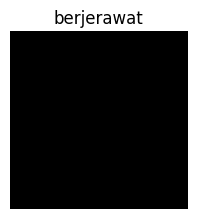

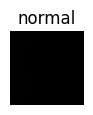

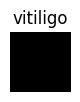

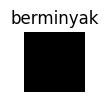

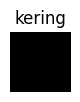

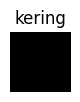

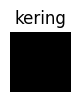

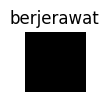

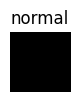

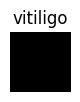

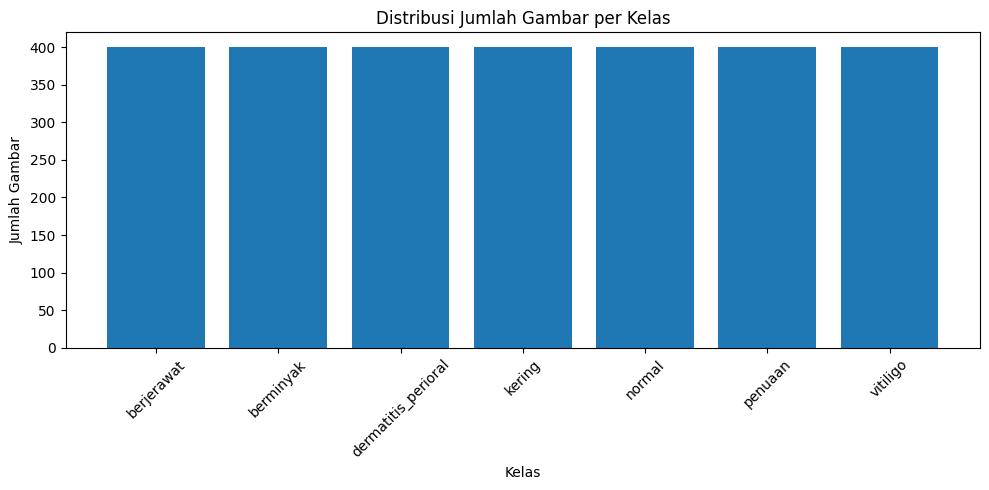

In [19]:
# --- KONSTANTAN GLOBAL (Jika belum didefinisikan di atas main()) ---
IMAGE_SHAPE = (224, 224, 3) # Ukuran input gambar (tinggi, lebar, channel)
BATCH_SIZE = 32 # Contoh batch size
LEARNING_RATE = 1e-3 # Contoh learning rate untuk transfer learning
FINE_TUNING_LEARNING_RATE = 1e-5 # Contoh learning rate untuk fine-tuning
CLASS_NAMES = ['Berjerawat', 'Berminyak', 'Kering', 'Vitiligo', 'Normal', 'Dermatitis_Perioral', 'Penuaaan'] # Contoh nama kelas

# --- FUNGSI PEMBANTU ---

def load_dataset(data_dir, batch_size):
    if not os.path.exists(data_dir):
        print(f"ERROR: Direktori dataset tidak ditemukan: {data_dir}")
        return None, None

    print(f"Memuat dataset dari: {data_dir}")
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='int',
        image_size=IMAGE_SHAPE[:2],
        interpolation='nearest',
        batch_size=batch_size,
        shuffle=True if "train" in data_dir else False
    )

    # Ambil nama-nama kelas
    detected_class_names = dataset.class_names

    # Normalisasi piksel
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    dataset = dataset.map(lambda x, y: (normalization_layer(x), y))

    # Optimasi I/O
    AUTOTUNE = tf.data.AUTOTUNE
    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

    return dataset, detected_class_names

# Panggil fungsi load_dataset
train_dataset, class_names = load_dataset("train", BATCH_SIZE)
# --- Visualisasi 10 gambar pertama ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(10):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
        plt.tight_layout()
        plt.show()


# --- Visualisasi distribusi kelas ---
from collections import Counter
import numpy as np

label_counter = Counter()
for _, labels in train_dataset.unbatch():
    label = labels.numpy()
    label_counter[label] += 1

labels_sorted = sorted(label_counter.keys())
counts = [label_counter[k] for k in labels_sorted]
class_names_sorted = [class_names[k] for k in labels_sorted]

plt.figure(figsize=(10, 5))
plt.bar(class_names_sorted, counts)
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
val_dataset, _ = load_dataset("validation", BATCH_SIZE)
test_dataset, _ = load_dataset("test", BATCH_SIZE)


Memuat dataset dari: validation
Found 875 files belonging to 7 classes.
Memuat dataset dari: test
Found 791 files belonging to 7 classes.


In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Base model tanpa top layer
base_model = MobileNetV2(input_shape=IMAGE_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base model saat awal training

# Bangun model akhir
inputs = tf.keras.Input(shape=IMAGE_SHAPE)
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
# Callback untuk early stopping dan simpan model terbaik
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model_feature_extraction.h5", save_best_only=True)
]

# Training awal (feature extraction)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.2994 - loss: 1.8296

88/88 ━━━━━━━━━━━━━━━━━━━━ 83s 897ms/step - accuracy: 0.3009 - loss: 1.8255 - val_accuracy: 0.6674 - val_loss: 0.9759
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.6473 - loss: 0.9879

88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 816ms/step - accuracy: 0.6476 - loss: 0.9871 - val_accuracy: 0.7451 - val_loss: 0.7326
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 641ms/step - accuracy: 0.7141 - loss: 0.7913

88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 819ms/step - accuracy: 0.7142 - loss: 0.7910 - val_accuracy: 0.7920 - val_loss: 0.6179
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.7580 - loss: 0.7032

88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 834ms/step - accuracy: 0.7581 - loss: 0.7029 - val_accuracy: 0.7920 - val_loss: 0.5647
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 660ms/step - accuracy: 0.7594 - loss: 0.6474

88/88 ━━━━━━━━━━━━━━━━━━━━ 74s 840ms/step - accuracy: 0.7596 - loss: 0.6471 - val_accuracy: 0.8217 - val_loss: 0.5137
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.7933 - loss: 0.5714

88/88 ━━━━━━━━━━━━━━━━━━━━ 73s 830ms/step - accuracy: 0.7934 - loss: 0.5712 - val_accuracy: 0.8286 - val_loss: 0.4718
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.8217 - loss: 0.5212

88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 823ms/step - accuracy: 0.8217 - loss: 0.5211 - val_accuracy: 0.8446 - val_loss: 0.4386
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.8085 - loss: 0.5265

88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 817ms/step - accuracy: 0.8086 - loss: 0.5262 - val_accuracy: 0.8491 - val_loss: 0.4131
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.8346 - loss: 0.4854

88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 825ms/step - accuracy: 0.8347 - loss: 0.4851 - val_accuracy: 0.8606 - val_loss: 0.3909
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 0.8306 - loss: 0.4665

88/88 ━━━━━━━━━━━━━━━━━━━━ 72s 822ms/step - accuracy: 0.8307 - loss: 0.4664 - val_accuracy: 0.8743 - val_loss: 0.3821


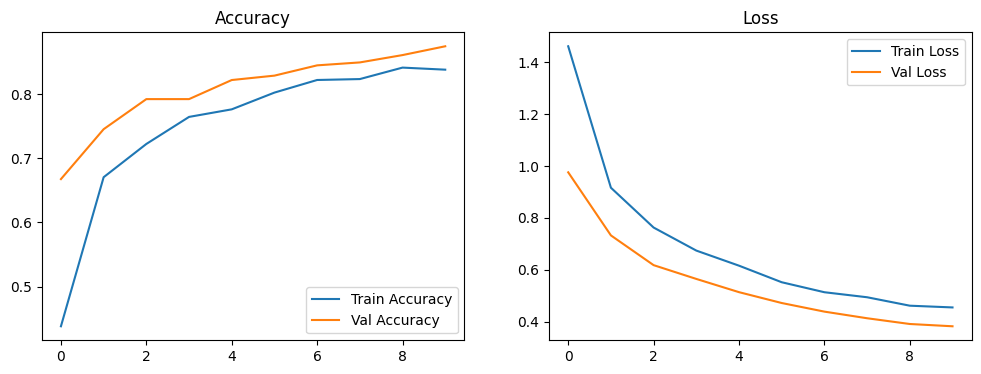

In [23]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

In [24]:
# Buka beberapa layer akhir dari base_model
base_model.trainable = True

# Opsional: Hanya buka layer ke-X sampai akhir (misal, 100 ke atas)
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Kompilasi ulang model dengan learning rate lebih kecil
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FINE_TUNING_LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Training lanjutan (fine-tuning)
fine_tune_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_model_fine_tuned.h5", save_best_only=True)
]

fine_tune_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=fine_tune_callbacks
)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5238 - loss: 1.4857

88/88 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.5244 - loss: 1.4834 - val_accuracy: 0.8469 - val_loss: 0.3946
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7243 - loss: 0.8291

88/88 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.7243 - loss: 0.8287 - val_accuracy: 0.8480 - val_loss: 0.3787
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7738 - loss: 0.6289

88/88 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.7738 - loss: 0.6286 - val_accuracy: 0.8617 - val_loss: 0.3604
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8218 - loss: 0.5183

88/88 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8219 - loss: 0.5181 - val_accuracy: 0.8709 - val_loss: 0.3416
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8259 - loss: 0.4780

88/88 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.8260 - loss: 0.4779 - val_accuracy: 0.8800 - val_loss: 0.3254
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8579 - loss: 0.3976

88/88 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8579 - loss: 0.3977 - val_accuracy: 0.8903 - val_loss: 0.3080
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8667 - loss: 0.3783

88/88 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8668 - loss: 0.3782 - val_accuracy: 0.8914 - val_loss: 0.2972
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8908 - loss: 0.3245

88/88 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8908 - loss: 0.3244 - val_accuracy: 0.8994 - val_loss: 0.2826
Epoch 9/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9015 - loss: 0.2975

88/88 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.9015 - loss: 0.2975 - val_accuracy: 0.9029 - val_loss: 0.2714
Epoch 10/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9128 - loss: 0.2531

88/88 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.9128 - loss: 0.2532 - val_accuracy: 0.9086 - val_loss: 0.2568


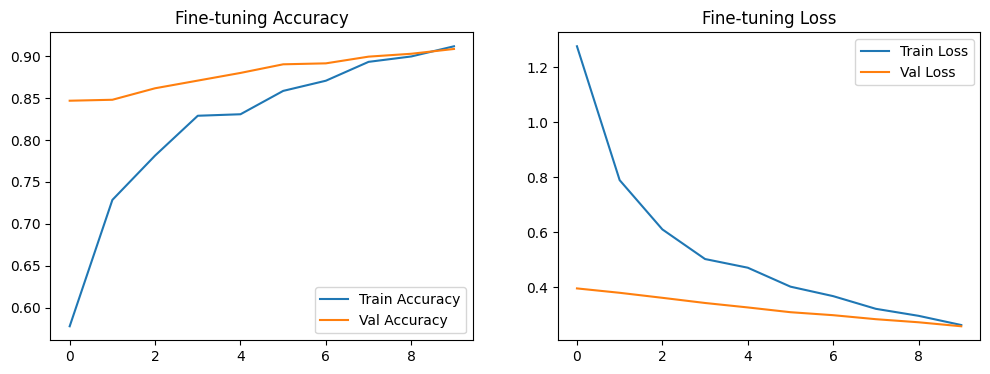

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Fine-tuning Accuracy')

plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Fine-tuning Loss')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 787ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 709ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 945ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


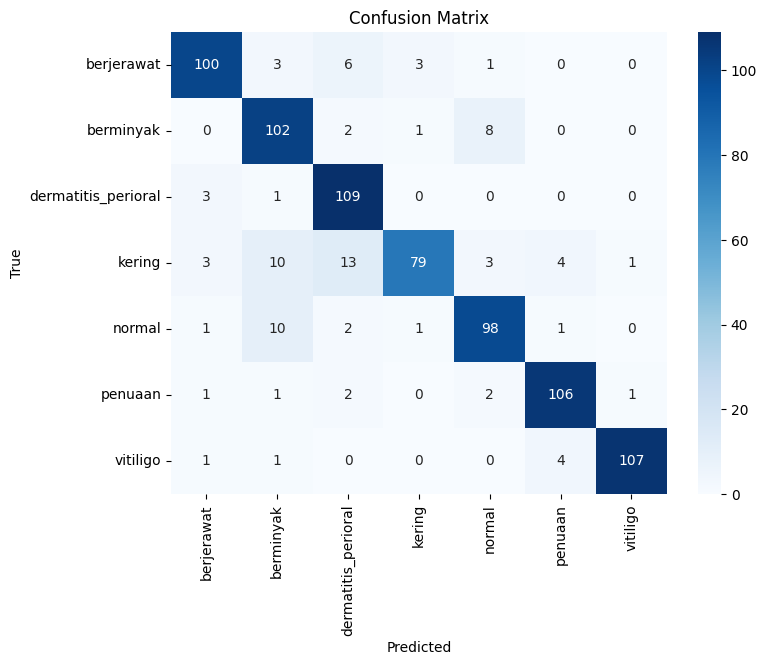

                     precision    recall  f1-score   support

         berjerawat       0.92      0.88      0.90       113
          berminyak       0.80      0.90      0.85       113
dermatitis_perioral       0.81      0.96      0.88       113
             kering       0.94      0.70      0.80       113
             normal       0.88      0.87      0.87       113
            penuaan       0.92      0.94      0.93       113
           vitiligo       0.98      0.95      0.96       113

           accuracy                           0.89       791
          macro avg       0.89      0.89      0.89       791
       weighted avg       0.89      0.89      0.89       791



In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Ambil prediksi dari test set
y_true = []
y_pred = []

for images, labels in test_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Laporan klasifikasi
print(classification_report(y_true, y_pred, target_names=class_names))


In [27]:
# Simpan model ke file .h5
model.save("model_klasifikasi_citra.h5")
print("✅ Model berhasil disimpan!")


✅ Model berhasil disimpan!


In [28]:
from tensorflow.keras.models import load_model

# Muat model dari file
model = load_model("model_klasifikasi_citra.h5")
print("✅ Model berhasil dimuat!")


✅ Model berhasil dimuat!


# Prediksi

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

def predict_single_image(img_path, model, class_names):
    # Load dan preprocess gambar
    img = image.load_img(img_path, target_size=IMAGE_SHAPE[:2])
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Tambah dimensi batch
    img_array = img_array / 255.0  # Normalisasi piksel

    # Prediksi
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Tampilkan gambar & prediksi
    plt.imshow(img)
    plt.title(f"Prediksi: {predicted_class}")
    plt.axis("off")
    plt.show()

    return predicted_class


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step


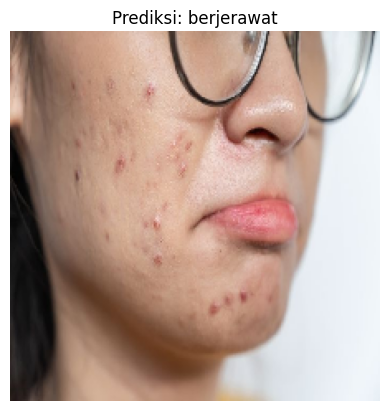

Hasil Prediksi: berjerawat


In [33]:
# Ganti path ke gambar yang ingin kamu prediksi
image_path = "3.jpg"

# Panggil fungsi prediksi
hasil = predict_single_image(image_path, model, class_names)
print("Hasil Prediksi:", hasil)
